# Objectives

1. Plot Locus Coverage of Whole Genome.
1. Add Locus Coverage to Dataframe.
1. Plot Locus Coverage: Distribution.
1. Plot Locus Coverage: Phlyo.
1. Identify Interesting Samples.

---
# Setup

## Imports

In [1]:
import os
import subprocess
from Bio import Phylo
import copy
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import lines, patches, colors, gridspec, ticker
import seaborn as sns
import scipy.stats
from functions import *

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import numpy as np


## Variables

In [2]:
#WILDCARDS = ["all", "chromosome", "full", "30"]
WILDCARDS = ["all", "chromosome", "full", "5"]
#project_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/denmark/"
#project_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/pla/"
project_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/"
results_dir = project_dir

READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
PRUNE = WILDCARDS[2]
MISSING_DATA = WILDCARDS[3]

NO_DATA_CHAR = "NA"

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)

plt.rcParams['lines.linewidth'] = 0.5

flierprops = dict(marker='o', markerfacecolor='black', markersize=1,
                   markeredgecolor='none')

D3_COL_PAL = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
D3_COL_PAL_REV = copy.copy(D3_COL_PAL)
D3_COL_PAL_REV.reverse()

# ------------------------------------------
# Plotting
plt.rcParams['axes.facecolor']    ='white'
plt.rcParams['savefig.facecolor'] ='white'
plt.rcParams['savefig.dpi']       = 400
plt.rcParams['svg.fonttype']      = 'none'

## Paths

In [3]:
colors_path = os.path.join(
    results_dir,
    "augur/{}/{}/{}/filter{}/beast/colors.tsv"
    .format(READS_ORIGIN, LOCUS_NAME, PRUNE, MISSING_DATA)
)

tree_path = os.path.join(
    results_dir, 
    "augur/{}/{}/{}/filter{}/beast/all.timetree.nwk"
    .format(READS_ORIGIN, LOCUS_NAME, PRUNE, MISSING_DATA)
)
metadata_path = os.path.join(
    results_dir, 
    "augur/{}/{}/{}/filter{}/ml/metadata.tsv"
    .format(READS_ORIGIN, LOCUS_NAME, PRUNE, MISSING_DATA)
)

#metadata_path = os.path.join(results_dir, "metadata/all/metadata.tsv"


cov_df_path = os.path.join(
    results_dir, 
    "locus_coverage_collect/{}/locus_coverage.txt"
    .format(READS_ORIGIN)
)

dep_df_path = os.path.join(
    results_dir, 
    "locus_coverage_collect/{}/locus_depth.txt"
    .format(READS_ORIGIN)
)
ref_gff_path = os.path.join(
    results_dir,
    "data/reference/GCA_000009065.1_ASM906v1_genomic/GCA_000009065.1_ASM906v1_genomic.gff"
)

# ------------------------------------------
# Output
out_dir = os.path.join(results_dir, "locus_coverage_collect/{}/".format(READS_ORIGIN))
print(out_dir)

/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/locus_coverage_collect/all/


## Import Tree

In [4]:
"""tree = Phylo.read(tree_path, format="newick")
tree.ladderize(reverse=True)"""

'tree = Phylo.read(tree_path, format="newick")\ntree.ladderize(reverse=True)'

## Import Metadata

In [5]:
metadata_df = pd.read_csv(metadata_path, sep='\t')
metadata_df.set_index(metadata_df.columns[0], inplace=True)
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

display(metadata_df)

print(metadata_df.columns)

,strain,date,date_bp,country,province,...,timetree_CI_upper_err,country_date_strain,province_date_strain,root_geo_dist,population_geo_dist
sample,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,...,0.0,United States of America (1992) CO92,United States of America (1992) CO92,11486.934170,11299.492458
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,...,0.0,Russia (1923.0) 9_10,Russia (1923.0) 9_10,3257.927659,3336.855636
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,...,0.0,China (2006.0) 42126,China (2006.0) 42126,823.027149,0.000000
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,...,0.0,China (2005.0) 42123,China (2005.0) 42123,823.027149,0.000000
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,...,0.0,China (2005.0) 42118,China (2005.0) 42118,823.027149,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
NODE595,NA,NA,NA,NA,NA,...,22.0,NA,NA,16711.452350,16887.182260
NODE596,NA,NA,NA,NA,NA,...,22.0,NA,NA,16711.452350,16887.182260
NODE597,NA,NA,NA,NA,NA,...,28.0,NA,NA,16711.452350,16887.182260


Index(['strain', 'date', 'date_bp', 'country', 'province', 'country_lat',
       'country_lon', 'province_lat', 'province_lon', 'biovar', 'branch_major',
       'branch_minor', 'biosample_accession', 'biosample_comment',
       'branch_number', 'continent', 'date_mean', 'date_bp_mean', 'date_err',
       'lat', 'lon', 'host_human', 'sequencing_technology', 'assembly_method',
       'host_raw', 'host_order', 'population_color', 'population', 'geometry',
       'root_rtt_dist', 'clade_rtt_dist', 'population_rtt_dist', 'tstv',
       'cds_sites', 'ns_sites', 'ss_sites', 'ns_ss_ratio', 'other_var',
       'other_var_ratio', 'homo_het_sites', 'homo_sites', 'het_sites',
       'het_ratio', 'external_branch_length', 'node_type', 'branch_length',
       'branch_support', 'branch_support_conf_char',
       'branch_support_conf_category', 'timetree_date', 'timetree_CI_height',
       'timetree_CI_date', 'mugration_country', 'mugration_province',
       'mugration_continent', 'mugration_host_orde

## Import Locus Dataframes

In [6]:
cov_df = pd.read_csv(cov_df_path, sep='\t')
cov_df.set_index("Sample", inplace=True)

print("Loaded Coverage")
#display(cov_df)  

dep_df = pd.read_csv(dep_df_path, sep='\t')
dep_df.set_index("Sample", inplace=True)
     
print("Loaded Depth")
#display(dep_df)

Loaded Coverage
Loaded Depth


In [7]:
# Remove samples not in tree dataframe (ex. outgroup)
for sample in cov_df.index:
    if sample not in metadata_df.index:
        print("Dropping:",sample)
        cov_df.drop(sample, inplace=True)
        dep_df.drop(sample, inplace=True)

# exception

#sample = "SAMN01991268"
#if sample in metadata_df.index:
#    cov_df.drop(sample, inplace=True)
#    dep_df.drop(sample, inplace=True)    

Dropping: GCA_900637475.1_51108_B01_genomic
Dropping: GCA_000834295.1_ASM83429v1_genomic


## Import Reference GFF

In [8]:
ref_gff_columns = [
        "seqname",
        "source",
        "feature",
        "start", #sequence numbering starting at 1.
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
        "id",
]

ref_gff_tsv = ref_gff_path + ".tsv"
subprocess.run(["rm", "-f", ref_gff_tsv]) 

with open(ref_gff_path) as infile:
    with open(ref_gff_tsv, "a") as outfile:
        ref_gff_read = infile.read().split("\n")
        for line in ref_gff_read:
            if not line.startswith("#"):
                split_line = line.strip().split("\t")
                attr = split_line[-1].split(";")
                attr_id = attr[0].split("=")
                if len(attr_id) < 2:
                    continue
                attr_id = attr_id[1]
                line += "\t{}".format(attr_id)
                outfile.write(line + "\n")
                
ref_df = pd.read_csv(ref_gff_tsv, sep='\t', header=None)
ref_df.columns = ref_gff_columns
ref_df.set_index("id", inplace=True)
#display(ref_df)

## Create Dataframes for replicons and genes

In [9]:
ref_rep_df = ref_df[ref_df["feature"] == "region"]
#display(ref_rep_df)

ref_gene_df = ref_df[ref_df["feature"] == "gene"]
#display(ref_gene_df)

## Separate Dataframe by Type

In [10]:
cov_rep_df = copy.deepcopy(cov_df)
cov_gene_df = copy.deepcopy(cov_df)
dep_rep_df = copy.deepcopy(dep_df)
dep_gene_df = copy.deepcopy(dep_df)
non_replicon_loci = []
non_gene_loci = []

for col in cov_df.columns:
    if col not in ref_rep_df.index:
        non_replicon_loci.append(col)
    if col not in ref_gene_df.index:
        non_gene_loci.append(col)
        
cov_rep_df.drop(columns=non_replicon_loci, inplace=True)
display(cov_rep_df)

dep_rep_df.drop(columns=non_replicon_loci, inplace=True)
#display(dep_rep_df)
       
cov_gene_df.drop(columns=non_gene_loci, inplace=True)
#display(cov_gene_df)

dep_gene_df.drop(columns=non_gene_loci, inplace=True)
#display(dep_gene_df)

,AL590842.1:1..4653728,AL117189.1:1..70305,AL117211.1:1..96210,AL109969.1:1..9612
Sample,,,,
GCA_009909635.1_ASM990963v1_genomic,0.919553,0.919181,0.938385,0.000000
GCA_009669545.1_ASM966954v1_genomic,0.947885,0.941384,0.941461,0.800666
GCA_009669555.1_ASM966955v1_genomic,0.945635,0.931143,0.940838,0.800250
GCA_009669565.1_ASM966956v1_genomic,0.947141,0.938070,0.939892,0.800458
GCA_009669605.1_ASM966960v1_genomic,0.948884,0.948012,0.941908,0.802122
...,...,...,...,...
SAMEA7313243_45,0.918001,0.937159,0.936088,0.802434
SAMEA7313246_49,0.959482,0.962136,0.945037,0.809925
SAMEA6651390,0.947021,0.941284,0.940225,0.803995


---
# pPCP1 Analysis

In [11]:
target_seqname = "AL109969"
target_locus = "AL109969.1:1..9612" # pPCP1
target_gene = "gene-YPPCP1.07" # pla

# Danish exlude
# exclude_samples = ["P187","P212","P387",]

# Exclude IS100 and the IS100 transposase
exclude_genes = ["gene-YPPCP1.01", "gene-YPPCP1.02" ]
gene_labels = {
    "gene-YPPCP1.01": 
        {
            "label": "IS100",
            "coord": [87, 1109],
            "color" : "#c4c4c4",
        },
    "gene-YPPCP1.02": 
        {
            "label": "IS100",
            "coord": [1106, 1888],
            "color" : "#c4c4c4",            
        },
    "gene-YPPCP1.03": 
        {
            "label": "rop",
            "coord": [2925, 3119],
            "color": "#1f77b4",
        },    
    "gene-YPPCP1.04": 
        {
            "label": "pim",
            "coord": [4355, 4780],
            "color": "#1f77b4",            
        },  
    "gene-YPPCP1.05c": 
        {
            "label": "pst",
             "coord": [4815, 5888],
            "color": "#1f77b4",            
        }, 
    "gene-YPPCP1.06": 
        {
            "label": "Hypothetical protein",
            "coord": [6006, 6422],
            "color": "#1f77b4",            
        },     
    "gene-YPPCP1.07": 
        {
            "label": "pla",
            "coord": [6665, 7603],
            "color" : "#ff7f0e",
        }, 
    "gene-YPPCP1.08c": 
        {
            "label": "Probable transcriptional regulator",
            "coord": [7790, 8089],
            "color" : "#ff7f0e",            
        }, 
    "gene-YPPCP1.09c": 
        {
            "label": "Hypothetical protein",
            "coord": [8089, 8436],
            "color" : "#ff7f0e",            
        },    
}

In [12]:
# Select the plasmid genes from the reference
ppcp1_genes = list(ref_gene_df[ref_gene_df["seqname"] == target_seqname].index)

# Select the depth
ppcp1_genes_df = dep_gene_df[ppcp1_genes]

display(ppcp1_genes_df)

,gene-YPPCP1.01,gene-YPPCP1.02,gene-YPPCP1.03,gene-YPPCP1.04,gene-YPPCP1.05c,gene-YPPCP1.06,gene-YPPCP1.07,gene-YPPCP1.08c,gene-YPPCP1.09c
Sample,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GCA_009669545.1_ASM966954v1_genomic,0.0,0.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
GCA_009669555.1_ASM966955v1_genomic,0.0,0.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
GCA_009669565.1_ASM966956v1_genomic,0.0,0.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
GCA_009669605.1_ASM966960v1_genomic,0.0,0.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
...,...,...,...,...,...,...,...,...,...
SAMEA7313243_45,0.0,0.196679,34.205128,31.990610,46.094971,62.119904,4.741214,6.743333,8.031610
SAMEA7313246_49,0.0,4.745849,256.743591,258.255859,263.231842,258.318939,192.029816,211.883331,194.339081
SAMEA6651390,0.0,0.217114,130.066666,78.983566,119.687149,105.657074,17.816826,34.653332,34.181034


---
## Calculate Depletion Ratio

In [13]:
# Gene ID
depleted_gene = "gene-YPPCP1.07" # pla
baseline_gene = "gene-YPPCP1.05c" #pst

# Gene Label
depleted_gene_label = gene_labels[depleted_gene]["label"]
baseline_gene_label = gene_labels[baseline_gene]["label"]

# Gene Depth
baseline_dep = list(ppcp1_genes_df[baseline_gene])
depleted_dep = list(ppcp1_genes_df[depleted_gene])

# Accessory plotting variables
sample = list(ppcp1_genes_df.index)
#timetree_num_date = metadata_df["timetree_num_date"][ppcp1_genes_df.index]
timetree_num_date = metadata_df["date_mean"][ppcp1_genes_df.index]
strain = metadata_df["strain"][ppcp1_genes_df.index]
#root_rtt_dist = metadata_df["root_rtt_dist"][ppcp1_genes_df.index]
country = metadata_df["country"][ppcp1_genes_df.index]
ratio = []
population = metadata_df["population"][ppcp1_genes_df.index]
host_order = metadata_df["host_order"][ppcp1_genes_df.index]

for depleted,baseline in zip(depleted_dep, baseline_dep):
    if baseline == 0:
        ratio.append(0)
    else:
        ratio.append(depleted/baseline)

data = {
    "baseline": baseline_dep, 
    "depleted": depleted_dep, 
    "ratio": ratio, 
    "sample" : sample,
    "timetree_num_date": timetree_num_date,
    "strain" : strain,
    "country" : country,
    "population" : population,
    "host_order" : host_order,
    #"root_rtt_dist" : root_rtt_dist,
    }

ratio_df = pd.DataFrame(data)
ratio_df.set_index("sample", inplace=True)
ratio_df.sort_values(by="ratio", inplace=True)
#ratio_df.sort_values(by="baseline", inplace=True)

display(ratio_df)

,baseline,depleted,ratio,timetree_num_date,strain,country,population,host_order
sample,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,0.000000,0.000000,0.000000,1923,9_10,Russia,2.MED,Human
GCA_001295045.1_ASM129504v1_genomic,0.000000,0.000000,0.000000,1971,C-290,Armenia,0.PE,Rodentia
GCA_001294815.1_ASM129481v1_genomic,0.000000,0.000000,0.000000,1983,C-590,Armenia,0.PE,Rodentia
GCA_001294825.1_ASM129482v1_genomic,0.000000,0.000000,0.000000,1984,C-537,Russia,0.PE,Rodentia
GCA_001295105.1_ASM129510v1_genomic,0.000000,0.000000,0.000000,1968,C-235,Azerbaijan,0.PE,Rodentia
...,...,...,...,...,...,...,...,...
GCA_000325265.1_ASM32526v1_genomic,5.307262,20.000000,3.768421,1997,MGJZ6,Mongolia,3.ANT,Rodentia
GCA_000323665.1_ASM32366v1_genomic,2.493482,11.043663,4.429012,1994,945,China,0.ANT,Siphonaptera
GCA_000323985.1_ASM32398v1_genomic,3.841713,20.000000,5.206011,1952,CMCC114001,China,1.ORI,Rodentia


## Filter Genomes

In [14]:
# Copy original dataframes
ppcp1_genes_orig_df = copy.deepcopy(ppcp1_genes_df)
ratio_orig_df = copy.deepcopy(ratio_df)

# New dataframes
ratio_df = ratio_orig_df
ppcp1_genes_df = ppcp1_genes_orig_df

# Keep only high cov samples
#high_cov_samples = list(dep_rep_df[dep_rep_df[target_locus] >= 10].index)
high_cov_samples = list(dep_rep_df[dep_rep_df[target_locus] >= 15].index)
ppcp1_genes_df   = ppcp1_genes_df.loc[high_cov_samples]
ratio_df         = ratio_df.loc[high_cov_samples]

# Exclude Local Danish samples
#ppcp1_genes_df.drop(index=exclude_samples, inplace=True)
#ratio_df.drop(index=exclude_samples, inplace=True)

# Exclude extremely high ratios
#high_ratio_samples = list(ratio_df[ratio_df["ratio"] >= 10].index)
#high_ratio_samples = list(ratio_df[ratio_df["ratio"] >= 3].index)
#ratio_df.drop(index=high_ratio_samples, inplace=True)

display(ppcp1_genes_df)
display(ratio_df.sort_values("ratio"))


,gene-YPPCP1.01,gene-YPPCP1.02,gene-YPPCP1.03,gene-YPPCP1.04,gene-YPPCP1.05c,gene-YPPCP1.06,gene-YPPCP1.07,gene-YPPCP1.08c,gene-YPPCP1.09c
Sample,,,,,,,,,
GCA_009669545.1_ASM966954v1_genomic,0.0,0.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
GCA_009669555.1_ASM966955v1_genomic,0.0,0.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
GCA_009669565.1_ASM966956v1_genomic,0.0,0.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
GCA_009669605.1_ASM966960v1_genomic,0.0,0.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
GCA_009669625.1_ASM966962v1_genomic,0.0,0.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
...,...,...,...,...,...,...,...,...,...
SAMEA7313243_45,0.0,0.196679,34.205128,31.990610,46.094971,62.119904,4.741214,6.743333,8.031610
SAMEA7313246_49,0.0,4.745849,256.743591,258.255859,263.231842,258.318939,192.029816,211.883331,194.339081
SAMEA6651390,0.0,0.217114,130.066666,78.983566,119.687149,105.657074,17.816826,34.653332,34.181034


,baseline,depleted,ratio,timetree_num_date,strain,country,population,host_order
sample,,,,,,,,
SAMEA5818798,64.481377,6.458999,0.100168,1597.5,BED024,England,1.PRE,Human
SAMEA7313243_45,46.094971,4.741214,0.102858,1550,Azov38,Russia,1.PRE,Human
SAMEA5818825,42.612663,4.544196,0.106640,1560,STN013,Switzerland,1.PRE,Human
SAMEA5818830,82.606148,9.773163,0.118310,1560,STN021,Switzerland,1.PRE,Human
SAMEA5818808,38.094971,4.517572,0.118587,1543.5,LBG002,Germany,1.PRE,Human
...,...,...,...,...,...,...,...,...
GCA_000324805.2_EV76-CN_genomic,19.274673,20.000000,1.037631,1926,EV76-CN,China,1.ORI,Human
GCA_000323965.1_ASM32396v1_genomic,19.265364,20.000000,1.038132,1954,CMCC11001,China,1.IN,Rodentia
GCA_000324245.1_ASM32424v1_genomic,19.250465,20.000000,1.038936,1954,CMCC51020,China,2.ANT,Rodentia


## Plot Gene coverage across plasmid

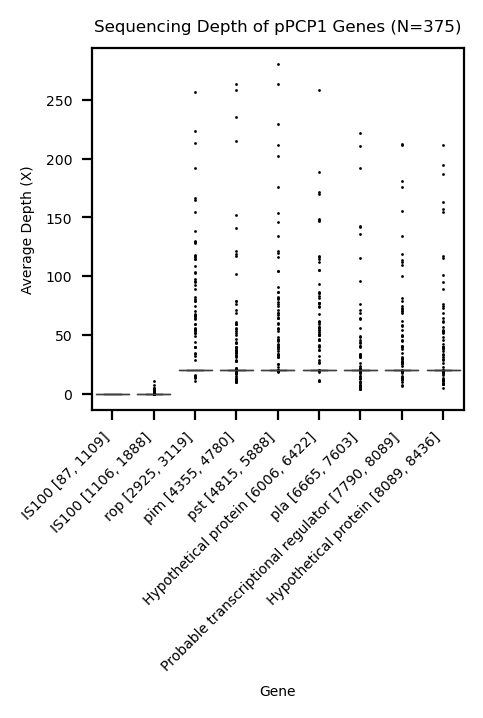

In [15]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
LOCUS_DEP = 10
RATIO = 0.7
plt.rc('font', size=FONTSIZE)

fig, axes = plt.subplots(1,1,figsize=FIGSIZE, dpi=DPI)

ax = axes
df = ppcp1_genes_df[ppcp1_genes_df["gene-YPPCP1.03"] > 10]
data = {
    col:list(df[col]) for col in df.columns
}
df = pd.DataFrame(data)
colors = [gene_labels[gene]["color"] for gene in gene_labels]
sns.boxplot(
    ax=ax,
    data=df,
    flierprops=flierprops,
    #showfliers=False,
    palette=colors,
)
xtick_labels = ["{} {}".format(gene_labels[gene]["label"],gene_labels[gene]["coord"])  for gene in gene_labels]
ax.set_xticklabels(xtick_labels)
plt.xticks(rotation=45, ha="right")
ax.set_xlabel("Gene")
ax.set_ylabel("Average Depth (X)")
plt.title("Sequencing Depth of pPCP1 Genes (N={})".format(len(df)))

out_path = os.path.join(out_dir, "ppcp1_gene_depth")
plt.savefig(out_path + ".png", dpi=DPI, bbox_inches = "tight", facecolor="white")
plt.savefig(out_path + ".svg", dpi=DPI, bbox_inches = "tight")

---
# Detect K Cluster

In [16]:
X = np.array(ratio_df["ratio"]).reshape(-1, 1)

### Elbow Method

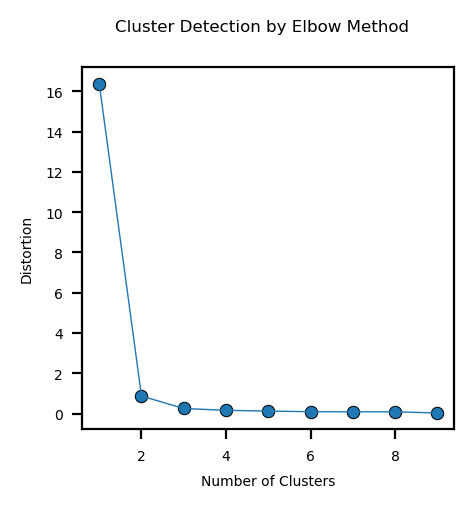

In [17]:
# calculate distortion for a range of number of cluster
distortions = []

iter = 10
for i in range(1, iter):
    km = KMeans(
        n_clusters=i, 
        init='random',
        n_init=10, 
        max_iter=300,
        tol=1e-04, 
        random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
LOCUS_DEP = 10
RATIO = 0.7
plt.rc('font', size=FONTSIZE)

fig, ax = plt.subplots(1,1,figsize=FIGSIZE, dpi=DPI)

sns.lineplot(
    ax=ax,
    x=range(1, iter), 
    y=distortions,
)
sns.scatterplot(
    ax=ax,
    x=range(1, iter), 
    y=distortions,
    s=20,
    ec="black",
    lw=0.5,
)

ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Distortion')
fig.suptitle("Cluster Detection by Elbow Method")

out_path = os.path.join(out_dir, "elbow_{}_{}".format(depleted_gene_label, baseline_gene_label))
plt.savefig(out_path + ".png", bbox_inches = "tight", facecolor="white")
plt.savefig(out_path + ".svg", bbox_inches = "tight")

## Silhoutte Clusters

In [18]:
range_n_clusters = [2, 3, 4, 5, 6]

highest_score = 0
highest_cluster = 0

for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    if silhouette_avg > highest_score:
        highest_cluster = n_clusters
        highest_score = silhouette_avg

print(highest_cluster)
# To Plot see: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For n_clusters = 2 The average silhouette_score is : 0.9630877167397391
For n_clusters = 3 The average silhouette_score is : 0.9334178529306187
For n_clusters = 4 The average silhouette_score is : 0.9223803522645055
For n_clusters = 5 The average silhouette_score is : 0.9029688898650935
For n_clusters = 6 The average silhouette_score is : 0.9068480574790129
2


---
# Cluster

### Manual Override

In [19]:
#highest_cluster = 2

In [20]:
km = KMeans(
    n_clusters=highest_cluster, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

for ratio, cluster, sample in zip(X, y_km, ratio_df.index):
    ratio_df.at[sample, "cluster"] = cluster
    
#display(ratio_df)
cluster_max_ratios = {cluster:0 for cluster in range(0, highest_cluster)}

for cluster in range(0, highest_cluster):
    ratios = [r[0] for r in X[y_km == cluster]]
    cluster_max_ratios[cluster] = max(ratios)

cluster_order = list({cluster:ratio for cluster,ratio in sorted(cluster_max_ratios.items(), key=lambda item: item[1])}.keys())

for rec in ratio_df.iterrows():
    sample = rec[0]
    cluster = rec[1]["cluster"]
    new_cluster = cluster_order.index(cluster)
    ratio_df.at[sample, "cluster"] = new_cluster
    
    
display(ratio_df)

,baseline,depleted,ratio,timetree_num_date,strain,country,population,host_order,cluster
sample,,,,,,,,,
GCA_009669545.1_ASM966954v1_genomic,20.000000,20.000000,1.000000,2006,42126,China,0.ANT,Rodentia,1.0
GCA_009669555.1_ASM966955v1_genomic,20.000000,20.000000,1.000000,2005,42123,China,0.ANT,Siphonaptera,1.0
GCA_009669565.1_ASM966956v1_genomic,20.000000,20.000000,1.000000,2005,42118,China,0.ANT,Rodentia,1.0
GCA_009669605.1_ASM966960v1_genomic,20.000000,20.000000,1.000000,2005,42117,China,0.ANT,Siphonaptera,1.0
GCA_009669625.1_ASM966962v1_genomic,20.000000,20.000000,1.000000,2005,42116,China,0.ANT,Rodentia,1.0
...,...,...,...,...,...,...,...,...,...
SAMEA7313243_45,46.094971,4.741214,0.102858,1550,Azov38,Russia,1.PRE,Human,0.0
SAMEA7313246_49,263.231842,192.029816,0.729508,1550,Gdansk8,Poland,1.PRE,Human,1.0
SAMEA6651390,119.687149,17.816826,0.148862,1456,AGU010,Lithuania,1.PRE,Human,0.0


---
## Plot

No handles with labels found to put in legend.
No handles with labels found to put in legend.


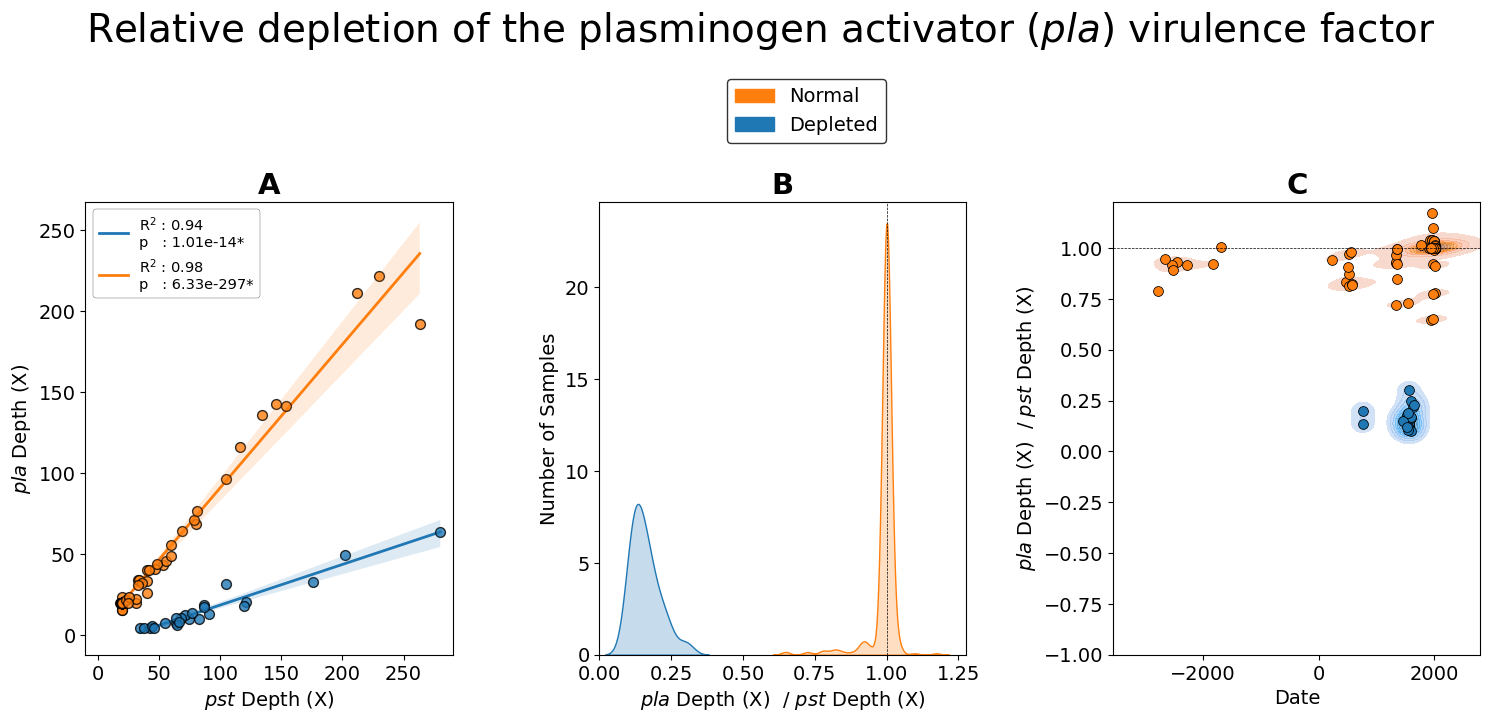

In [24]:
FONTSIZE=14
plt.rc('font', size=FONTSIZE)
DPI=100
FIGSIZE=[18,6]
## All
fig, axes = plt.subplots(1,3,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.4, hspace=0.4)


#------------------------------------------------
# Regresion
#ax = axes[0][0]
ax = axes[0]

ax.set_title("A", fontsize=FONTSIZE * 1.5, fontweight="bold")

attr = "cluster"
reg_handles = []


for attr_val in set(ratio_df[attr]):
    attr_df = ratio_df[ratio_df[attr] == attr_val]
    # Regression Line
    sns.regplot(
        ax=ax,
        data=attr_df,
        x="baseline",
        y="depleted", 
        #ci=None,
        scatter_kws={"s": 50, "ec":"black", "lw": 1, "zorder":1,},   
        line_kws={"zorder":0, "lw":2 },
        color=D3_COL_PAL[int(attr_val)]
    )

    if len(attr_df) < 2: continue
    # Stats Label
    x = list(attr_df["baseline"])
    y = list(attr_df["depleted"])
    slope, intercept, r_value, p_value, stderr, = scipy.stats.linregress(x,y)
    p_sig = ""
    if p_value < 0.05:
        p_sig = "*"
        
    r_squared = r_value * r_value
    r_squared_pretty = str(round(r_squared, 2))
    
    intercept_pretty = "+ " + str(round(intercept, 2)).replace("+","")
    if "-" in str(intercept):
        intercept_pretty = "- " + str(round(intercept, 2)).replace("-","")
        
    reg_handles.append(
        lines.Line2D([0], [0], lw=2,
        label = (
            "R$^{2}$ : " + "{}".format(r_squared_pretty)
            #"y = {}x {}".format(round(slope,2),intercept_pretty)
            + "\np   : {:0.2e}{}".format(p_value, p_sig)
        ),
        color=D3_COL_PAL[int(attr_val)]),
    )  
    
    
ax.set_xlabel("$\it{" + "{}".format(baseline_gene_label) + "}$ Depth (X)")
ax.set_ylabel("$\it{" + "{}".format(depleted_gene_label) + "}$ Depth (X)")
ax.set_xlim(-10, max(ratio_df["baseline"] + 10))

legend = ax.legend(handles=reg_handles, loc=2, fontsize=FONTSIZE * 0.75, edgecolor="black")
legend.get_frame().set_linewidth(0.25)

#------------------------------------------------
# Histogram
ax = axes[1]

ax.set_title("B", fontsize=FONTSIZE * 1.5, fontweight="bold")
ax.axvline(1, ls="--", color="black")
for attr_val in set(ratio_df[attr]):
    attr_df = ratio_df[ratio_df[attr] == attr_val]
    
    """sns.histplot(
        ax=ax,
        data=attr_df,
        x="ratio",
        bins=len(attr_df),
        color=D3_COL_PAL[int(attr_val)],
        alpha=0.75,
        zorder=0,
    )"""
    sns.kdeplot(
        ax=ax,
        data=attr_df,
        x="ratio",
        color=D3_COL_PAL[int(attr_val)],
        fill=True,
        zorder=1,
    )    

ax.set_xlim(0)
ax.set_ylabel("Number of Samples")
ax.set_xlabel(
    "$\it{" 
    + "{}".format(depleted_gene_label)
    + "}$ Depth (X)  / $\it{"
    + "{}".format(baseline_gene_label)
    + "}$ Depth (X)")
ax.legend().remove()
#ax.set_ylim(0,20)

# --------------------------------------
# TIMELINE
ax = axes[2]
ax.set_title("C", fontsize=FONTSIZE * 1.5, fontweight="bold")
ax.axhline(1, ls="--", color="black")
for attr_val in set(ratio_df[attr]):
    attr_df = ratio_df[ratio_df[attr] == attr_val]
    sns.scatterplot(
        ax=ax, 
        data=attr_df, 
        x="timetree_num_date", 
        y="ratio",
        s=50,
        ec="black",
        color=D3_COL_PAL[int(attr_val)],        
        zorder=2,
    )
    sns.kdeplot(
        ax=ax, 
        data=attr_df, 
        x=list(attr_df["timetree_num_date"]), 
        y=list(attr_df["ratio"]),
        fill=True,
        color=D3_COL_PAL[int(attr_val)],  
        zorder=1,
        alpha=0.5,
    )    

ax.legend().remove()

ax.set_xlabel("Date")
ax.set_ylabel(
    "$\it{" 
    + "{}".format(depleted_gene_label)
    + "}$ Depth (X)  / $\it{"
    + "{}".format(baseline_gene_label)
    + "}$ Depth (X)")
ax.set_ylim(-1,)

#------------------------------------------------
# Legend
#normal_patch = patches.Patch(color=D3_COL_PAL[1], label='Normal $\it{pla}$')
normal_patch = patches.Patch(color=D3_COL_PAL[1], label='Normal')
#low_patch = patches.Patch(color=D3_COL_PAL[0], label='Depleted $\it{pla}$')
low_patch = patches.Patch(color=D3_COL_PAL[0], label='Depleted')
#legend = fig.legend(handles=[normal_patch, low_patch], bbox_to_anchor=(0.6,0.98), edgecolor="black")
legend = fig.legend(handles=[normal_patch, low_patch], bbox_to_anchor=(0.575,1.1), edgecolor="black")
legend.get_frame().set_linewidth(1)

fig.suptitle(
    "Relative depletion of the plasminogen activator ($\it{pla}$) virulence factor", 
    x=0.5, 
    y=1.2, 
    fontsize=FONTSIZE * 2,
)

out_path = os.path.join(out_dir, "depletion_{}".format(depleted_gene_label))
plt.savefig(out_path + ".png", bbox_inches = "tight")
plt.savefig(out_path + ".svg", bbox_inches = "tight")

In [25]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

delim="|"
columns = [
    "population",
    "strain",
    "country",
    "timetree_num_date",
    "ratio",
    "baseline",
    "host_order",
]

header = delim.join(columns) 

for attr_val in set(ratio_df[attr]):
    print(attr_val)
    #print("|" + header + "|")
    attr_df = ratio_df[ratio_df[attr] == attr_val]
    display(attr_df.sort_values("ratio"))
    for sample in attr_df.index:
        vals = [str(attr_df[column][sample]) for column in columns]
        line = delim.join(vals)
        #print("|" + line + "|")


0.0


,baseline,depleted,ratio,timetree_num_date,strain,country,population,host_order,cluster
sample,,,,,,,,,
SAMEA5818798,64.481377,6.458999,0.100168,1597.5,BED024,England,1.PRE,Human,0.0
SAMEA7313243_45,46.094971,4.741214,0.102858,1550,Azov38,Russia,1.PRE,Human,0.0
SAMEA5818825,42.612663,4.544196,0.106640,1560,STN013,Switzerland,1.PRE,Human,0.0
SAMEA5818830,82.606148,9.773163,0.118310,1560,STN021,Switzerland,1.PRE,Human,0.0
SAMEA5818808,38.094971,4.517572,0.118587,1543.5,LBG002,Germany,1.PRE,Human,0.0
SAMEA5818828,64.391991,7.680511,0.119277,1560,STN019,Switzerland,1.PRE,Human,0.0
SAMEA6637004,66.663872,7.968051,0.119526,1526.5,AGU025,Lithuania,1.PRE,Human,0.0
SAMEA5818822,34.228119,4.317359,0.126135,1560,STN008,Switzerland,1.PRE,Human,0.0
SAMEA5818821,75.030724,10.085197,0.134414,1560,STN007,Switzerland,1.PRE,Human,0.0


1.0


,baseline,depleted,ratio,timetree_num_date,strain,country,population,host_order,cluster
sample,,,,,,,,,
GCA_900460465.1_57940_B01_genomic,40.000000,25.921192,0.648030,1939,NCTC5923,Indonesia,1.ORI,NA,1.0
GCA_001261985.1_YPW_3_IHQD_genomic,31.016760,20.112886,0.648452,1970.5,EV76D,Madagascar,1.ORI,NA,1.0
SAMEA5818811,31.121973,22.412140,0.720139,1342,NAB003,Germany,1.PRE,Human,1.0
SAMEA7313246_49,263.231842,192.029816,0.729508,1550,Gdansk8,Poland,1.PRE,Human,1.0
GCA_001188675.1_ASM118867v1_genomic,20.000000,15.521832,0.776092,1968.5,790,Kyrgyzstan,0.ANT,NA,1.0
GCA_000834885.1_ASM83488v1_genomic,20.000000,15.527157,0.776358,2008,Nicholisk 41,China,2.ANT,NA,1.0
SAMEA3541827,25.129423,19.813631,0.788463,-2776.5,RISE509,Russia,0.PRE,Human,1.0
SAMEA5661389,53.316574,43.336529,0.812815,516,UNT003,Germany,0.ANT4,Human,1.0
SAMEA5661364,59.592178,48.633652,0.816108,575,EDI003,England,0.ANT4,Human,1.0


## Add Depletion Statistics to Metadata

In [ ]:
metadata_df["baseline_{}".format(baseline_gene_label)] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["depleted_{}".format(depleted_gene_label)] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["ratio_{}_{}".format(depleted_gene_label, baseline_gene_label)] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["cluster_{}_{}".format(depleted_gene_label, baseline_gene_label)] = [NO_DATA_CHAR] * len(metadata_df)

# Including filter
#for rec in ratio_df.iterrows():
# Excluding filtering
for sample in ratio_orig_df.index:
    metadata_df.at[sample, "baseline_{}".format(baseline_gene_label)] = ratio_orig_df["baseline"][sample]
    metadata_df.at[sample, "depleted_{}".format(depleted_gene_label)] = ratio_orig_df["depleted"][sample]
    metadata_df.at[sample, "ratio_{}_{}".format(depleted_gene_label, baseline_gene_label)] = ratio_orig_df["ratio"][sample]
    if sample in ratio_df.index:
        metadata_df.at[sample, "cluster_{}_{}".format(depleted_gene_label, baseline_gene_label)] = ratio_df["cluster"][sample]
    
display(metadata_df)

## Draw Tree

In [ ]:
for c in tree.get_terminals():
    sample = c.name
    cluster = metadata_df["cluster_{}_{}".format(depleted_gene_label, baseline_gene_label)][sample]
    if cluster == NO_DATA_CHAR:
        color = "#c4c4c4"
    else:
        color = D3_COL_PAL[int(cluster)]
    c.color = color

# ---------------------------------------
# PLOT SETUP
TARGET_RES = [960, 960]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=4
LOCUS_DEP = 10
RATIO = 0.7
plt.rc('font', size=FONTSIZE)

fig, ax = plt.subplots(1,figsize=FIGSIZE, dpi=DPI)

Phylo.draw(
    tree, 
    axes=ax, 
    show_confidence=False, 
    #label_func = lambda x: metadata_df["country_date_strain"][x.name] if x.is_terminal() else "", 
    label_func = lambda x: "",
    do_show=False
)

ax.axis("off")
#ax.set_ylabel("")
#ax.set_yticklabels([])
#ax.set_xlabel("Years")

#------------------------------------------------
# Legend
normal_patch = patches.Patch(color=D3_COL_PAL[1], label='Normal $\it{pla}$')
low_patch = patches.Patch(color=D3_COL_PAL[0], label='Depleted $\it{pla}$')
unknown_patch = patches.Patch(color="#c4c4c4", label='Unknown $\it{pla}$')
legend = fig.legend(handles=[normal_patch, low_patch, unknown_patch], loc=6, edgecolor="black")
legend.get_frame().set_linewidth(0.5)

out_path = os.path.join(out_dir, "depletion_tree_{}".format(depleted_gene_label))
plt.savefig(out_path + ".png", bbox_inches = "tight", facecolor="white", dpi=DPI)
plt.savefig(out_path + ".svg", bbox_inches = "tight")

# Export

## Metadata

In [ ]:
out_path_metadata = os.path.join(out_dir, "metadata.tsv")
metadata_df.to_csv(out_path_metadata, sep="\t", index=True)

## Timetree

In [ ]:
out_tree = copy.deepcopy(tree)

metadata_to_comment(out_tree, metadata_df)    
out_path_tree_nex = os.path.join(out_dir, "all.timetree.nex")
Phylo.write(out_tree, out_path_tree_nex, "nexus")

## Prior Distribution

In [ ]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=4
LOCUS_DEP = 10
RATIO = 0.7
plt.rc('font', size=FONTSIZE)

priors = {
    "Denmark": {"mu": 1330, "range" : 230}, 
    "Rostov2033": {"mu": 1767.5, "range": 2.75 },
    "Azov38": {"mu":2021-471.0, "range": 75.0},
    "CHE1" : {"mu": 2021-371.0, "range" :75.0}, 
    "BED" : {"mu": 2021-423.5, "range" : 18.75}
}

for prior in priors:
          
    fig, ax = plt.subplots(1,figsize=FIGSIZE, dpi=DPI)


    mu = priors[prior]["mu"]
    date_range = priors[prior]["range"]
    sigma = date_range / 2
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = scipy.stats.norm.pdf(x, mu, sigma)

    ax.fill_between(x, y, alpha=0.25)

    sns.lineplot(ax=ax, x=x, y=y)
    #ax.plot(x, scipy.stats.norm.pdf(x, mu, sigma))
    ax.set_title("{} Collection Date Prior".format(prior), fontsize=FONTSIZE * 1.5, y=1.1)
    ax.set_xlabel("Date", fontsize=FONTSIZE * 1.5)
    ax.set_ylabel("Density", fontsize=FONTSIZE * 1.5)

    ax.axvline(x=mu, color="black", label="Mean Site Date")
    ax.axvline(x=mu - date_range, color="black", linestyle="--", label="Site Date Range")
    ax.axvline(x=mu + date_range, color="black", linestyle="--",)
    ax.legend(bbox_to_anchor=(0.30,1), edgecolor="black").get_frame().set_linewidth(0.5)


#out_path = os.path.join(out_dir, "prior_denmark")
#plt.savefig(out_path + ".png", bbox_inches = "tight", facecolor="white")
#plt.savefig(out_path + ".svg", bbox_inches = "tight")